In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *
import scipy

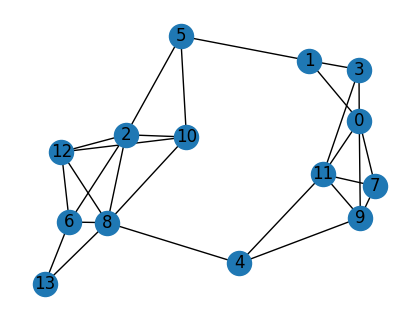

0.39302634464023445


In [22]:
# random network graph
N = 14# number of nodes
node_list = np.arange(N)

L0 = 1
length = L0
width = L0
dmax = 0.4*L0
# np.random.seed = 3
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

print(nx.shortest_path_length(G, source=4, target=8, weight="weight"))

In [32]:
from pulp import *
from math import *

prob = LpProblem("memory", LpMinimize)

Nmax = 10
Lmax = .5
D0 = 2
D = D0*np.ones(N)
s_list = [13,12,10] # source
t_list = [9,11,7] # destination
C = len(s_list)

# indices: (superscript, subscript)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

x = LpVariable.matrix("x", (list(range(C)),list(range(N)),list(range(N))), 0, 1, LpInteger)
yu = LpVariable.matrix("yu", list(range(N)), 0, 1, LpInteger)

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
    number = 0
    path_s = x[user_pair][s][t]
    path_t = x[user_pair][s][t]
    for n1 in R_list:
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            prob +=  l_uv*x[user_pair][s][n1] <= Lmax  
            path_length += l_uv*x[user_pair][s][n1]
        else:
            prob +=  x[user_pair][s][n1] == 0 
            
        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            prob +=  l_uv*x[user_pair][n1][t] <= Lmax 
            path_length += l_uv*x[user_pair][n1][t]
        else:
            prob +=  x[user_pair][n1][t] == 0 
            
        path = x[user_pair][n1][t] - x[user_pair][s][n1]
        number += x[user_pair][s][n1]+ x[user_pair][n1][t]
        path_s += x[user_pair][s][n1]
        path_t += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    prob +=  l_uv*x[user_pair][n1][n2] <= Lmax  
                    path_length += l_uv*x[user_pair][n1][n2]
                else:
                    prob +=  x[user_pair][n1][n2] == 0 
                    
                path += x[user_pair][n1][n2] - x[user_pair][n2][n1]
                number += x[user_pair][n1][n2]
                
        prob +=  path == 0 
    prob +=  number <= Nmax + 1 
    prob +=  path_s == 1 
    prob +=  path_t == 1 
    prob +=  nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][s][t] <= Lmax  

    
for n1 in R_list:
    y_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        y_const += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                y_const += x[user_pair][n1][n2]

    prob += y_const <= D[n1]*yu[n1]  


# y_sum = 0
# for n1 in range(N):
#     prob +=  yu[n1] <= D0 
#     prob +=  0 <= yu[n1]  
#     if (n1 not in s_list) and (n1 not in t_list):
#         y_sum += yu[n1]

# The objective is the total cost
prob += lpSum(yu)
# Solve the problem
prob.solve()

print("Minimum total cost:", prob.objective.value())


x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = value(yu[i])
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = value(x[user_pair][i][j])



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/hshapour/.conda/envs/QR/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/8a9bf1b0bd5d4a65a991f6c167d09bf1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/3z/cqx0rxzn29116x691bywsldm0000gn/T/8a9bf1b0bd5d4a65a991f6c167d09bf1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 265 COLUMNS
At line 1819 RHS
At line 2080 BOUNDS
At line 2314 ENDATA
Problem MODEL has 260 rows, 233 columns and 1073 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.826857 - 0.00 seconds
Cgl0004I processed model has 39 rows, 85 columns (85 integer (85 of which binary)) and 307 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 4 integers unsatisfied sum - 2
Cbc0038I Pass   1: suminf.    2.00000 (4) ob

[0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
(13, 9) : [array([4, 9]), array([8, 4]), array([13,  8])]
(12, 11) : [array([ 4, 11]), array([8, 4]), array([12,  8])]
(10, 7) : [[1, 0, 7], array([5, 1]), array([10,  5])]


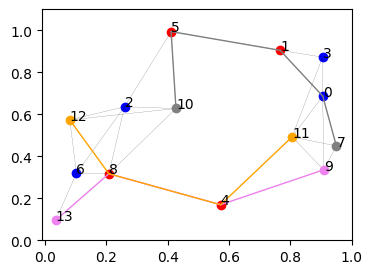

In [33]:
print(y_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y_val in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y_val >= 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
#             plt.text(pos[i][0],pos[i][1],"%d,%d" % (i,y_val))
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
     
for e in G.edges():
    plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)

colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.xlim([-0.01,1])
plt.ylim([0,1.1])
plt.show()
